# Dynamic Learner Showcase

Notebook created with the intent of showing how different tecniques deal with a dynamic environment

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters, simple_abrupt_change
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n 
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import random

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_avg_experiments(n_days, breakpoint, n_rewards, avg_clair_1, avg_clair_2, title, reward_color='cornflowerblue', regret_color='salmon', std_color='salmon'):

    avg_reward = np.average(n_rewards, axis=0)
    std_reward = np.std(n_rewards, axis=0)
    x = np.arange(n_days)
    
    avg_clairvoyant_reward = np.ones(n_days)
    avg_clairvoyant_reward[:breakpoint] *= avg_clair_1
    avg_clairvoyant_reward[breakpoint:] *= avg_clair_2
    
    avg_regret = avg_clairvoyant_reward - avg_reward
    avg_regret[avg_regret<0] = 0
    avg_regret = np.cumsum(avg_regret)
    
    upper_std_regret = avg_clairvoyant_reward - avg_reward + std_reward
    upper_std_regret[upper_std_regret<0] = 0
    upper_std_regret = np.cumsum(upper_std_regret)

    lower_std_regret = avg_clairvoyant_reward - avg_reward - std_reward
    lower_std_regret[lower_std_regret<0] = 0
    lower_std_regret = np.cumsum(lower_std_regret)

    clairvoyant_plot = avg_clairvoyant_reward

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(avg_reward, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} average reward over {len(n_rewards)} experiments')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[0].fill_between(x, (avg_reward-std_reward), (avg_reward+std_reward), color=std_color, alpha=.1, label= 'std')

    ax[1].plot(avg_regret, color=regret_color)
    ax[1].title.set_text(f'{title} average regret over {len(n_rewards)} experiments')

    ax[1].fill_between(x, lower_std_regret, upper_std_regret, color=std_color, alpha=.1)
        
    plt.show()

In [3]:
def abrupt_change(env, 
                  product_losing=2, 
                  product_losing2=0, 
                  product_gaining=1, 
                  product_gaining2=3,
                  lose_interest_factor=0.15,
                  gain_interest_factor=4
                 ):
    simple_abrupt_change(env, product_losing, lose_interest_factor)
    simple_abrupt_change(env, product_losing2, lose_interest_factor)
    simple_abrupt_change(env, product_gaining2, gain_interest_factor)
    simple_abrupt_change(env, product_gaining, gain_interest_factor)

In [4]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.2, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.5, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 80),
                UserClassParameters(20, 0.05, 360),
            ],
            [
                UserClassParameters(33, 0.4, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 300),
                UserClassParameters(36, 0.05, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=400,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[3, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.7, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.05, 0, 0, 0.25, 0],
            ]
        ),
    )
    return env

#### Environment setup
Create the environment reference with customizable parameters.

In [5]:
plt.style.use('seaborn-v0_8-dark')
# Random Number Generator used as a source of randomness by the environment and the simulation
seed=1501
rng = np.random.default_rng(seed=seed)
env = make_env(rng)

## Simulating abrupt change with basic learner
The simulation is ran using a learner with aggregated data and unknown alpha functions. This learner has no ability to adapt to a dynamic environment.

In [6]:
# Simulation separated default parameters
sim_n_days = 80
breakpoint = 30 # Must be smaller than sim_n_days
sim_n_experiments = 10
seed = 1501

population_mean = 1000
population_variance = 10
n_budget_steps = 20

In [7]:
avg_clair1 = clairvoyant_reward(env, population_mean, env.total_budget, n_budget_steps)
abrupt_change(env)
avg_clair2 = clairvoyant_reward(env, population_mean, env.total_budget, n_budget_steps)

In [8]:
sim_seed = seed
base_learner_rewards = list()

# Running multiple simulations
for _ in range(sim_n_experiments):

    rng = np.random.default_rng(sim_seed)
    env = make_env(rng) 

    simulation = Simulation(
    rng,
    env,
    step=Step.ONE,
    n_budget_steps=n_budget_steps,
    population_mean=population_mean,
    population_variance=population_variance,
    mab_algorithm=Mab.GPUCB1,
    )

    # Running the simulation
    simulation.simulate(breakpoint)
    abrupt_change(env)
    simulation.simulate(sim_n_days-breakpoint)

    base_learner_rewards.append(simulation.rewards)
    sim_seed += 1

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

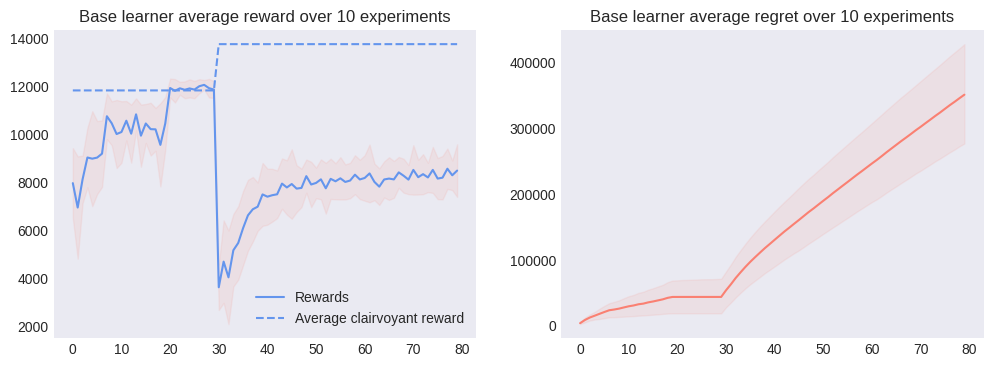

In [9]:
plot_avg_experiments(sim_n_days, breakpoint, base_learner_rewards, avg_clair1, avg_clair2, 'Base learner')

In [48]:
# Computing empiric regret
avg = np.average(base_learner_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clair1 * breakpoint + avg_clair2 * (sim_n_days - breakpoint) - total_rew

print(f'Static learner empiric regret over a {sim_n_days} days horizon: {empiric_regret}')

Static learner empiric regret over a 80 days horizon: 349712.6


## Abrupt change with Sliding-Window learner

In [13]:
sim_seed = seed
sw_learner_rewards = list()

# Running multiple simulations
for _ in range(sim_n_experiments):

    rng = np.random.default_rng(sim_seed)
    env = make_env(rng) 

    # Creating the simulation
    simulation = Simulation(
        rng,
        env,
        step=Step.FOUR,
        n_budget_steps=n_budget_steps,
        population_mean=population_mean,
        population_variance=population_variance,
        mab_algorithm=Mab.GPUCB1,
        sliding_window=True,
        window_size=35,
        units_less=False
    )

    # Running the simulation
    simulation.simulate(breakpoint)
    abrupt_change(env)
    simulation.simulate(sim_n_days-breakpoint)

    sw_learner_rewards.append(simulation.rewards)
    sim_seed += 1

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/30 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

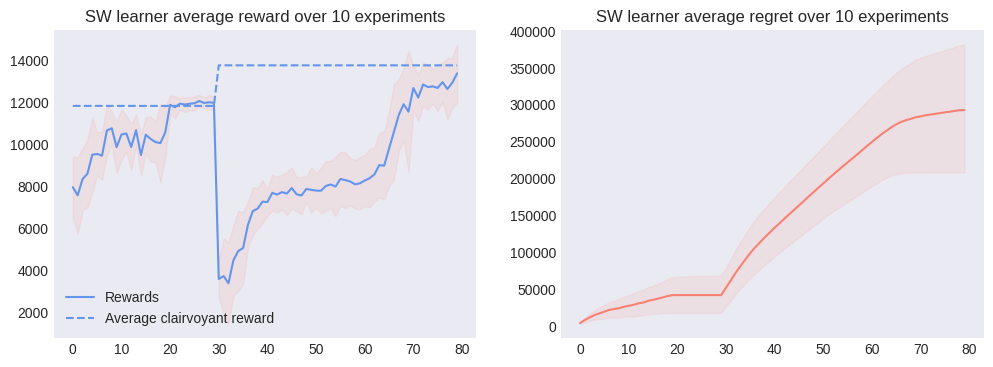

In [14]:
plot_avg_experiments(sim_n_days, breakpoint, sw_learner_rewards, avg_clair1, avg_clair2, 'SW learner')

In [50]:
# Computing empiric regret
avg = np.average(sw_learner_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clair1 * breakpoint + avg_clair2 * (sim_n_days - breakpoint) - total_rew

print(f'SW learner empiric regret over a {sim_n_days} days horizon: {empiric_regret}')

SW learner empiric regret over a 80 days horizon: 291777.40000000014


## Abrupt change with Change-Detection learner

In [ ]:
sim_seed = seed
cd_learner_rewards = list()

# Running multiple simulations
for _ in range(sim_n_experiments):

    rng = np.random.default_rng(sim_seed)
    env = make_env(rng) 

    # Creating the simulation
    simulation = Simulation(
        rng,
        env,
        step=Step.FOUR,
        n_budget_steps=n_budget_steps,
        population_mean=population_mean,
        population_variance=population_variance,
        mab_algorithm=Mab.GPUCB1,
        sliding_window=False,
        threshold=1500,
        threshold_window=4,
        units_less=False
    )

    # Running the simulation
    simulation.simulate(breakpoint)
    abrupt_change(env)
    simulation.simulate(sim_n_days-breakpoint)

    cd_learner_rewards.append(simulation.rewards)
    sim_seed += 1

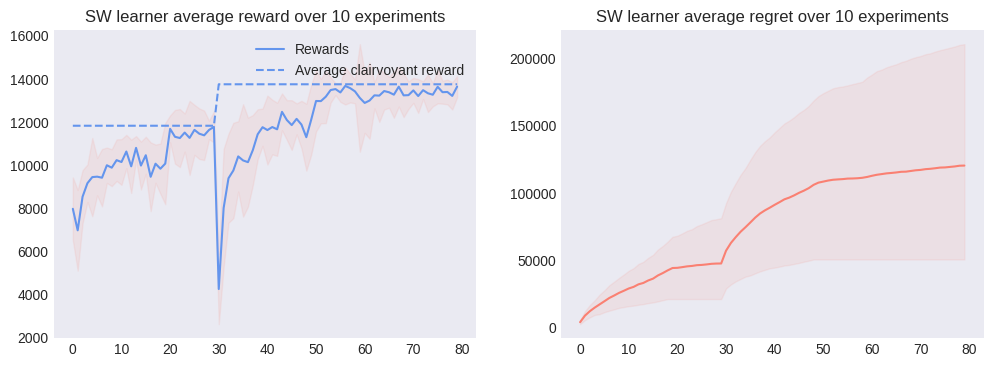

In [16]:
plot_avg_experiments(sim_n_days, breakpoint, cd_learner_rewards, avg_clair1, avg_clair2, 'SW learner')

In [51]:
# Computing empiric regret
avg = np.average(cd_learner_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clair1 * breakpoint + avg_clair2 * (sim_n_days - breakpoint) - total_rew

print(f'SW learner empiric regret over a {sim_n_days} days horizon: {empiric_regret}')

SW learner empiric regret over a 80 days horizon: 120340.5


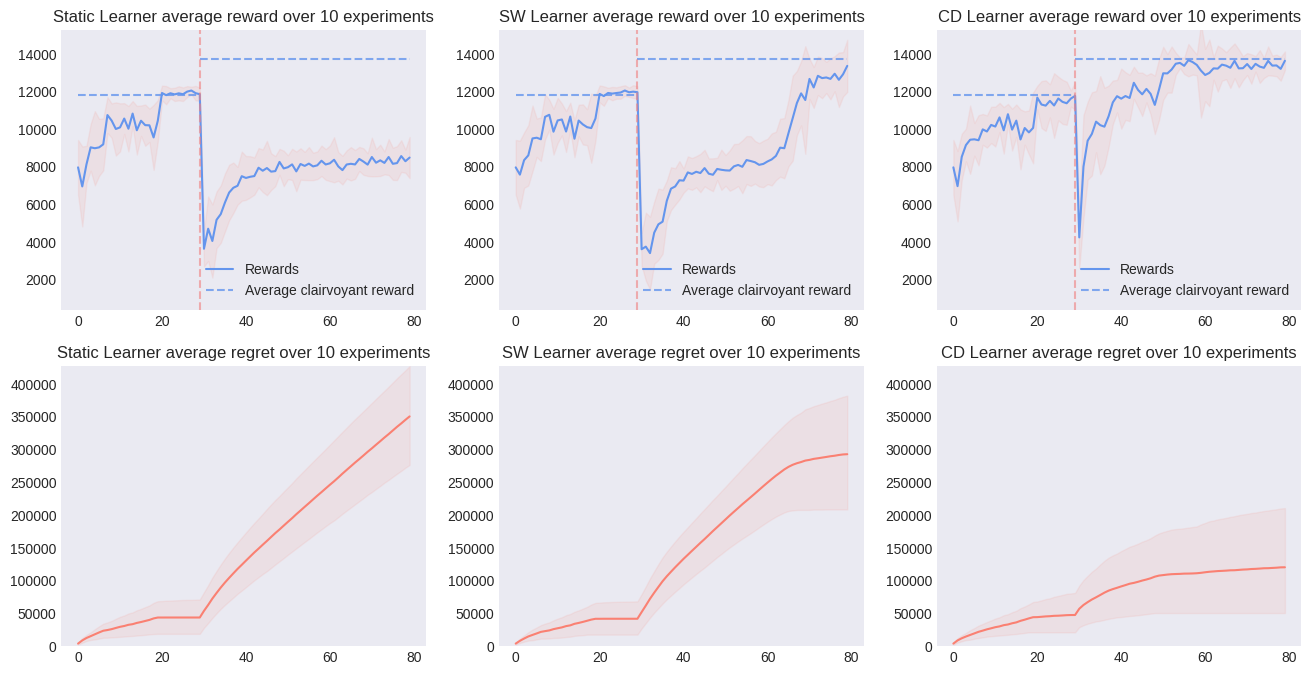

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

rewards = [base_learner_rewards, sw_learner_rewards, cd_learner_rewards]

maximum_reward = np.max(rewards)
minimum_reward = np.min(rewards)

regrets = []

for rew, graph, title in zip(rewards, ax.T, ['Static Learner', 'SW Learner', 'CD Learner']):
    avg_reward = np.average(rew, axis=0)
    std_reward = np.std(rew, axis=0)
    x = np.arange(sim_n_days)
    
    avg_clairvoyant_reward = np.ones(sim_n_days)
    avg_clairvoyant_reward[:breakpoint] *= avg_clair1
    avg_clairvoyant_reward[breakpoint:] *= avg_clair2
    
    avg_regret = avg_clairvoyant_reward - avg_reward
    avg_regret[avg_regret<0] = 0
    avg_regret = np.cumsum(avg_regret)
    
    upper_std_regret = avg_clairvoyant_reward - avg_reward + std_reward
    upper_std_regret[upper_std_regret<0] = 0
    upper_std_regret = np.cumsum(upper_std_regret)

    lower_std_regret = avg_clairvoyant_reward - avg_reward - std_reward
    lower_std_regret[lower_std_regret<0] = 0
    lower_std_regret = np.cumsum(lower_std_regret)

    clairvoyant_plot = avg_clairvoyant_reward
    
    regrets.append(upper_std_regret[-1])

    graph[0].plot(avg_reward, color='cornflowerblue', label='Rewards')
    graph[0].title.set_text(f'{title} average reward over {sim_n_experiments} experiments')
    graph[0].plot(x[:breakpoint], np.ones(breakpoint)*avg_clair1, color='cornflowerblue', alpha=.8, linestyle='--', label='Average clairvoyant reward')
    graph[0].plot(x[breakpoint-1:], np.ones(sim_n_days-breakpoint+1)*avg_clair2, color='cornflowerblue', alpha=.8, linestyle='--')
    graph[0].legend(loc='best')
    graph[0].axvline(x = breakpoint-1, alpha=0.6, color = 'lightcoral', linestyle='--', label= 'Abrupt change')
    graph[0].fill_between(x, (avg_reward-std_reward), (avg_reward+std_reward), color='salmon', alpha=.1, label= 'std')

    graph[1].plot(avg_regret, color='salmon')
    graph[1].title.set_text(f'{title} average regret over {sim_n_experiments} experiments')
    graph[1].fill_between(x, lower_std_regret, upper_std_regret, color='salmon', alpha=.1)
    
    graph[0].set_ylim([minimum_reward-1000, maximum_reward+200])
    graph[1].set_ylim([0, np.max(regrets)])
        
plt.show()